# Importing Kinematic modelling into GemPy using pynoddy

In [1]:
import sys, os
# Path to development gempy
sys.path.append('../../..')

# Path to development pynoddy
sys.path.append('../../../../pynoddy')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pn
# adjust some settings for matplotlib
from matplotlib import rcParams
# print rcParams
rcParams['font.size'] = 15
# determine path of repository to set paths corretly below
repo_path = os.path.realpath('../..')
import gempy as gp
import pynoddy
import pynoddy.history
import pynoddy.output
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Making your favorite model in pynoddy
### Loading noddy model

In [24]:
#reload(pynoddy.history)
# Downloading a model
his = pynoddy.history.NoddyHistory(url = \
            "http://tectonique.net/asg/ch2/ch2_2/ch2_2_1/his/normal.his")

his.determine_model_stratigraphy()

In [25]:
# Choosing resolution
his.change_cube_size(200)

In [26]:
# Writing history file
history_name = "fold_thrust.his"
his.write_history(history_name)

In [27]:
# Computing history file
output = "fold_thrust_out"
pynoddy.compute_model(history_name, output, sim_type='BLOCK')

''

In [28]:
# load and visualise model
h_out = pynoddy.output.NoddyOutput(output)

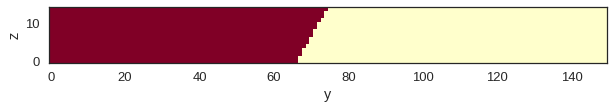

In [29]:
# his.determine_model_stratigraphy()
h_out.plot_section('x', 
                   layer_labels = his.model_stratigraphy, 
                   colorbar_orientation = 'horizontal', 
                   colorbar=False,
                   title = '',
#                   savefig=True, fig_filename = 'fold_thrust_NS_section.eps',
                   cmap = 'YlOrRd')

In [9]:
# Checkpoint. Saving noddy litholody block
np.save('noddy_block', h_out.block)

In [10]:
resolution

[150, 150, 15]

## GemPy finding interface points

In [2]:
# Creating geo_data with the same data extent and resolution as the noddy model

# initialize geo_data object
geo_data = gp.create_data([-8000, 38000, 
                           -8000, 38000, 
                           -5000, 3000],
                          resolution=[50, 50, 50])
block = np.load('noddy_block.npy')

In [3]:
extent = [0, 30000.0,
          0, 30000.0,
          0, 3000.0  ]# h_out.extent_x, h_out.extent_y, h_out.extent_z

cs = 200 #h_out.delx

resolution = [int(extent[1]/cs), 
              int(extent[3]/cs), 
              int(extent[5]/cs)]

noddy_grid = gp.GridClass.create_regular_grid_3d(extent, resolution)

In [4]:
# Importing some points at the interface
gp.utils.set_interfaces_from_block(geo_data, block, noddy_grid, reset_index=True)

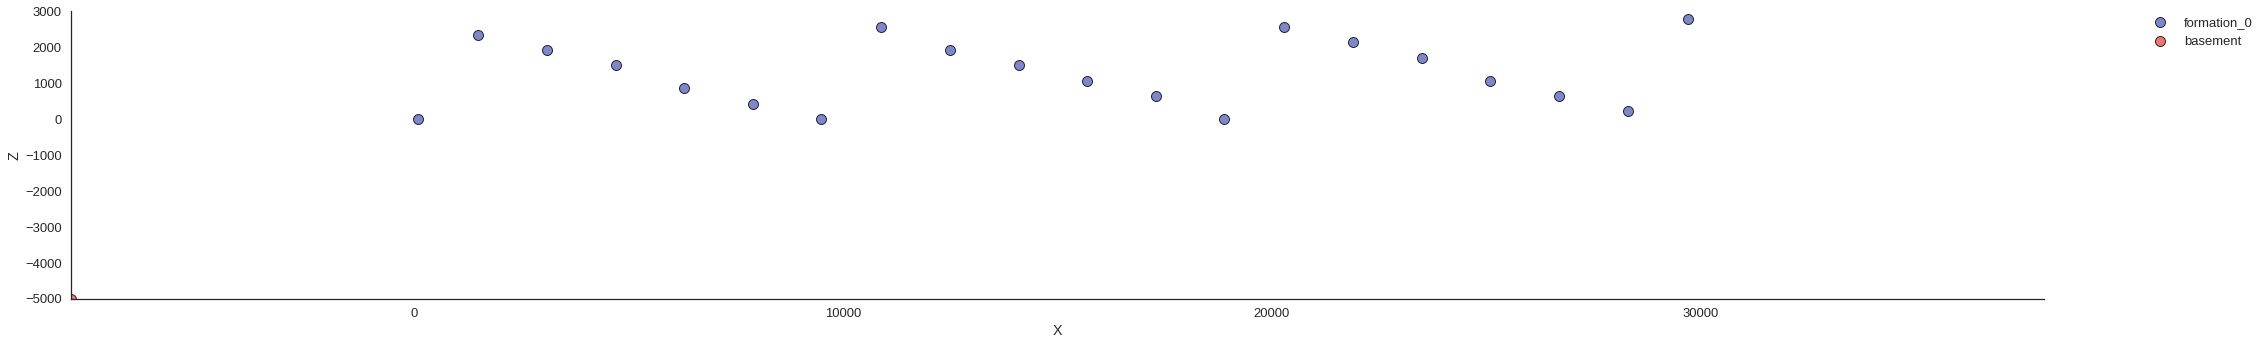

In [5]:
# Visualiziing
%matplotlib inline
gp.plotting.plot_data(geo_data)

In [6]:
geo_data.interfaces.head()

,X,Y,Z,annotations,formation,formation_number,formation_value,isFault,order_series,series
0,26700.0,13500.0,648.571411,"${\bf{x}}_{\alpha \,{\bf{0}},0}$",formation_0,1,1,False,1,Default series
1,12500.0,14300.0,1925.714233,"${\bf{x}}_{\alpha \,{\bf{0}},18}$",formation_0,1,1,False,1,Default series
2,100.0,13300.0,10.000000,"${\bf{x}}_{\alpha \,{\bf{0}},17}$",formation_0,1,1,False,1,Default series
3,1500.0,14500.0,2351.428467,"${\bf{x}}_{\alpha \,{\bf{0}},16}$",formation_0,1,1,False,1,Default series
4,3100.0,14300.0,1925.714233,"${\bf{x}}_{\alpha \,{\bf{0}},15}$",formation_0,1,1,False,1,Default series


In [7]:
geo_data.extent

array([-8000, 38000, -8000, 38000, -5000,  3000])

In [8]:
# Setting orientation from interfaces
gp.set_orientation_from_interfaces(geo_data, [5,6,7,8,9,10,11,12])

,X,Y,Z,G_x,G_y,G_z,dip,azimuth,polarity,formation,series,formation_number,order_series,isFault,annotations,formation_value
0,14125.0,13900.0,1180.714283,-0.003451,-0.875319,0.483534,61.083522,180.225899,1.0,formation_0,Default series,1,1,False,"${\bf{x}}_{\beta \,{\bf{1}},0}$",1


In [9]:
#gp.plotting.plot_data_3D(geo_data)

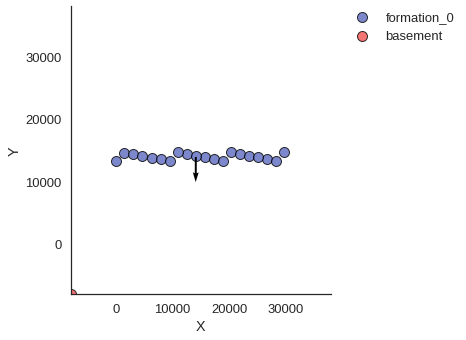

In [10]:
gp.plotting.plot_data(geo_data, direction='z')

### Computing and visualizing gempy model

In [18]:
interp_data = gp.InterpolatorData(geo_data, compile_theano=True)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [19]:
lith, fault = gp.compute_model(interp_data)

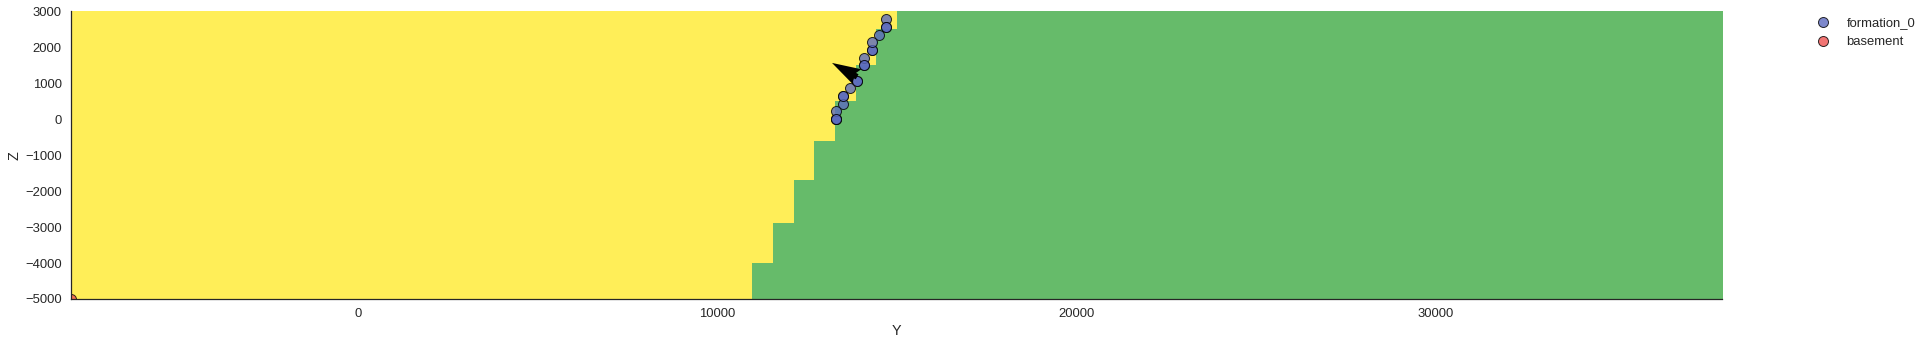

In [20]:
%matplotlib inline
gp.plotting.plot_section(geo_data, lith[0], 25, direction='x', plot_data= True)

In [21]:
ver, sim = gp.get_surfaces(interp_data, lith[1], None)
#gp.plotting.plot_surfaces_3D_real_time(geo_data, interp_data, ver, sim)

closing vtk


## Comparing physics
### pynoddy gravity

Density is 2.5 and 3.5

In [30]:
pynoddy.compute_model(history_name, output, sim_type = 'GEOPHYSICS')

''

In [31]:
geophys1 = pynoddy.output.NoddyGeophysics(output)

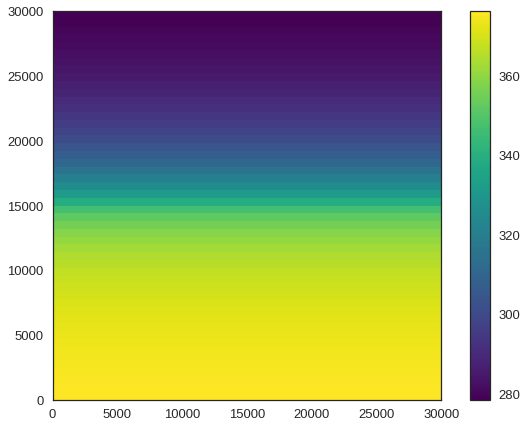

In [32]:
import matplotlib.pyplot as plt

plt.imshow(geophys1.grv_data, cmap='viridis', origin='lower',
           extent=extent[:-2] )
plt.colorbar()

### GemPy Gravity

In [11]:
gp.get_data(geo_data, 'formations')

,value,formation_number
formation_0,1,1
basement,2,2


In [12]:
gp.set_formations(geo_data, formations_values=[2.5, 3.5])

,value,formation_number
formation_0,2.5,1
basement,3.5,2


In [13]:
interp_data_grav = gp.InterpolatorData(geo_data, output='gravity',
                                       compile_theano=True)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [14]:
gp.set_geophysics_obj(interp_data_grav,
                      extent,
                      [50, 50])


In [15]:
gp.precomputations_gravity(interp_data_grav, 20);

In [16]:
geo_data.resolution

array([50, 50, 50])

In [32]:


x_g = geo_data.grid.values[:,0].reshape(geo_data.resolution)[40:,:,:]
y_g = geo_data.grid.values[:,1].reshape(geo_data.resolution)[40:,:,:]
z_g = geo_data.grid.values[:,2].reshape(geo_data.resolution)[40:,:,:]

In [33]:
import vtkInterface
import numpy as np
#[7.050000e+05,747000,6863000,6925000,-20000, 200

# Lith block grid
grid = vtkInterface.StructuredGrid(
x_g, y_g, z_g
                               )
# Fixing lith block direction
e = lith[0].reshape(geo_data.resolution)[40:,:,:]
g = e.swapaxes(0,2)

# Gravity  mesh

#.reshape(20,30), cmap='viridis', origin='lower', alpha=0.8, extent=[0,20e3,0,10e3]
# x_v = np.linspace(0, 20e3, 30)
# y_v = np.linspace(0, 10e3, 20)
# z_v = 1500
# x, y, z = np.meshgrid(x_v, y_v, z_v)

# a = vtkInterface.StructuredGrid(x,y, z)

In [34]:
import copy

col = copy.deepcopy(gp.plotting.colors.cmap)
plobj = vtkInterface.PlotClass()
plobj.AddMesh(grid, scalars= g,
              showedges=True,
              interpolatebeforemap=False, colormap=col,
              lighting=False)

(vtkRenderingOpenGL2Python.vtkOpenGLActor)0x7f7d00ce2648

In [35]:
plobj.Plot()

[(111644.58604944659, -10776.932388691555, 42548.484325326244),
 (26500.0, 15000.0, -1000.0),
 (-0.46352217926509576, -0.03527665698198497, 0.885382824998041)]

In [17]:
np.unique(interp_data_grav.geophy.airborne_plane[:, 2])

array([ 0.55556722])

In [18]:
interp_data_grav.geo_data_res.x_to_interp_given[:,2].max()

0.55356722266402103

In [133]:
interp_data_grav.update_interpolator(geo_data)

In [36]:
interp_data_grav.geophy.range_max

0.094297082228116669

In [39]:
interp_data_grav.geo_data_res.extent[5]-interp_data_grav.geo_data_res.extent[4]

0.1061007957559682

In [40]:
interp_data_grav.geo_data_res.extent

array([ 0.2501    ,  0.86017958,  0.3495695 ,  0.95964907,  0.44852743,
        0.55462823])

In [134]:
interp_data_grav.interpolator.tg.tz.get_value()[0].sum()

0.68249464

In [20]:
lith2, fault, grav = gp.compute_model(interp_data_grav, 'gravity')

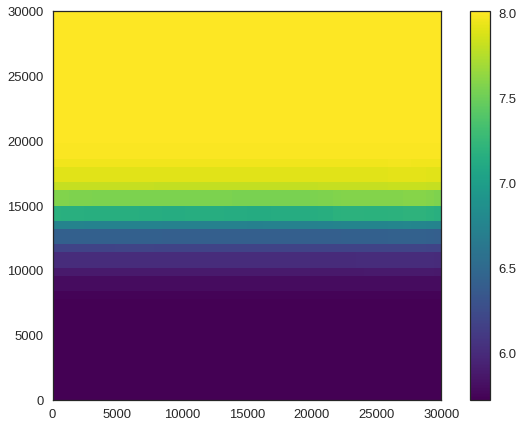

In [21]:
import matplotlib.pyplot as plt

plt.imshow(grav.reshape(50, 50), cmap='viridis', origin='lower',
           extent=extent[:-2] )
plt.colorbar()

### Comparing gravities

We set gempy values to to noddys

In [33]:
G = grav.reshape(50, 50)
N = geophys1.grv_data

# rs_min, rs_max = np.min(grav_real['G']), np.max(grav_real['G'])
# rs_range = rs_max - rs_min
# rs_mid = 0.5*(rs_max+rs_min)

# Calibration parameters
G_min, G_max =  np.min(G), np.max(G)   #36.630742, 36.651496    #30.159309, 30.174104#
N_min, N_max = np.min(N), np.max(N)

# Average
G_mid = 0.5 * (G_max + G_min)
N_mid = 0.5 * (N_max + N_min)

# Shifting
G_range = G_max - G_min
N_range = N_max - N_min
 

# Rescaling
Reescaled_G = N_mid + (G - G_mid) / G_range * N_range

# e_sq = T.sqrt(T.sum(T.square(Reescaled_G - (grav_real_th))))

(376.189, 376.18897500000003, 278.55209, 278.55208800000003)

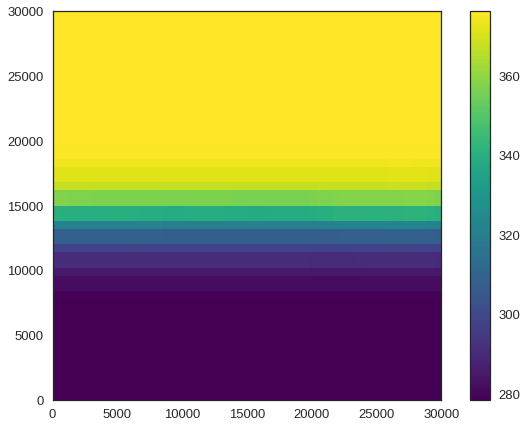

In [34]:
import matplotlib.pyplot as plt

plt.imshow(Reescaled_G.reshape(50, 50), cmap='viridis', origin='lower',
           extent=extent[:-2] )
plt.colorbar()
Reescaled_G.max(), N.max(), Reescaled_G.min(), N.min()

### Dif plot

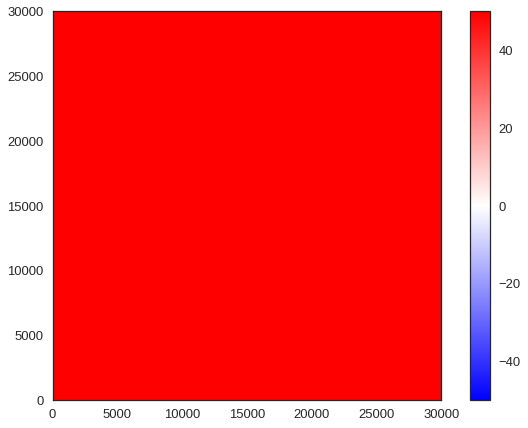

In [38]:
plt.imshow(Reescaled_G + N, cmap='bwr', origin='R',
           extent=extent[:-2], vmin=-50, vmax=50)
plt.colorbar()

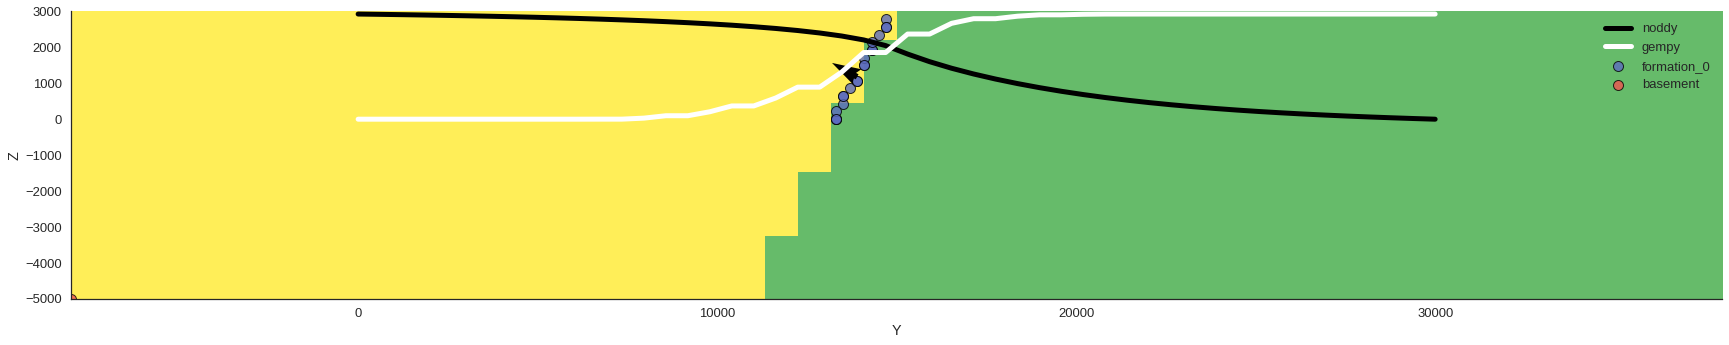

In [37]:
# # his.determine_model_stratigraphy()
# h_out.plot_section('x', 
#                    layer_labels = his.model_stratigraphy, 
#                    colorbar_orientation = 'horizontal', 
#                    colorbar=False,
#                    title = '',
# #                   savefig=True, fig_filename = 'fold_thrust_NS_section.eps',
#                    cmap = 'YlOrRd')

gp.plotting.plot_section(geo_data, lith2[0], 30, direction='x', plot_data= True)
plt.plot(np.linspace(0,30000, 50),
         (geophys1.grv_data[:,25] - geophys1.grv_data[:,0].min()) * 30, linewidth = 5, label = 'noddy', c='black')
plt.plot(np.linspace(0,30000, 50),
          (Reescaled_G[:, 0] - Reescaled_G[:, 25].min()) * 30,  linewidth = 5, label = 'gempy', c = 'white')
plt.legend()

In [30]:
grav.reshape(50, 50)[:, 0] 

array([ 1.74333119,  1.74333119,  1.74333119,  1.74333119,  1.74333119,
        1.74333119,  1.74333119,  1.74333119,  1.74333119,  1.74342871,
        1.75033331,  1.76679206,  1.79112649,  1.82364154,  1.86370587,
        1.91272306,  1.97329605,  2.13619423,  2.24294043,  2.36975527,
        2.51510119,  2.6642108 ,  2.74467134,  2.71150923,  2.64108276,
        2.59232497,  2.55815768,  2.53238177,  2.51216555,  2.49623895,
        2.48189807,  2.47007823,  2.45945096,  2.44456005,  2.44114304,
        2.44066358,  2.44066358,  2.44066358,  2.44066358,  2.44066358,
        2.44066358,  2.44066358,  2.44066358,  2.44066358,  2.44066358,
        2.44066358,  2.44066358,  2.44066358,  2.44066358,  2.44066358], dtype=float32)

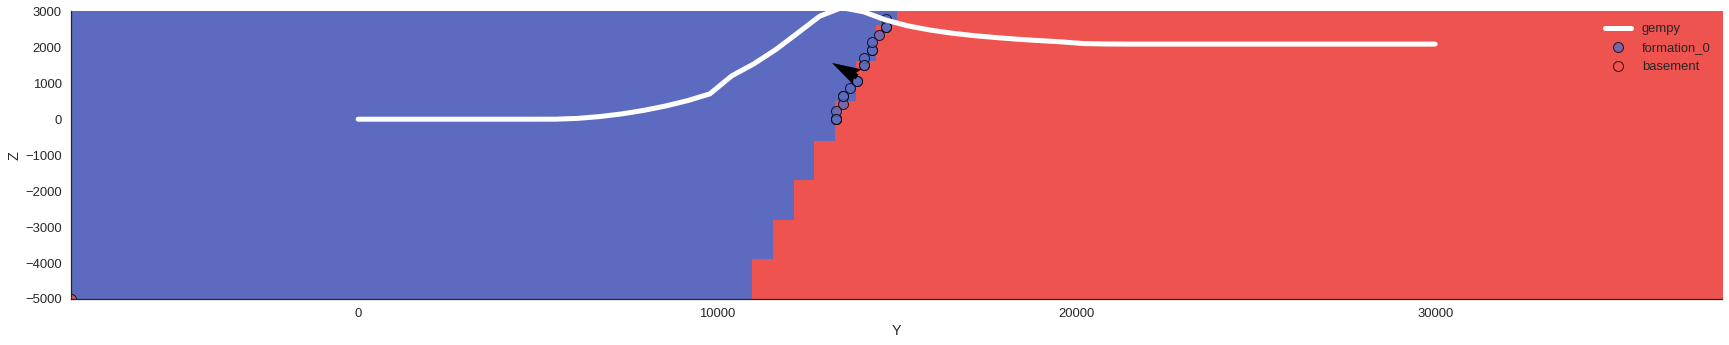

In [31]:
gp.plotting.plot_section(geo_data, lith[0], 30, direction='x', plot_data= True)

plt.plot(np.linspace(0,30000, 50),
          (grav.reshape(50, 50)[:, 25] - grav.reshape(50, 50)[:, 25].min()) * 3000,  linewidth = 5, label = 'gempy', c = 'white')
plt.legend()


<IPython.core.display.Javascript object>


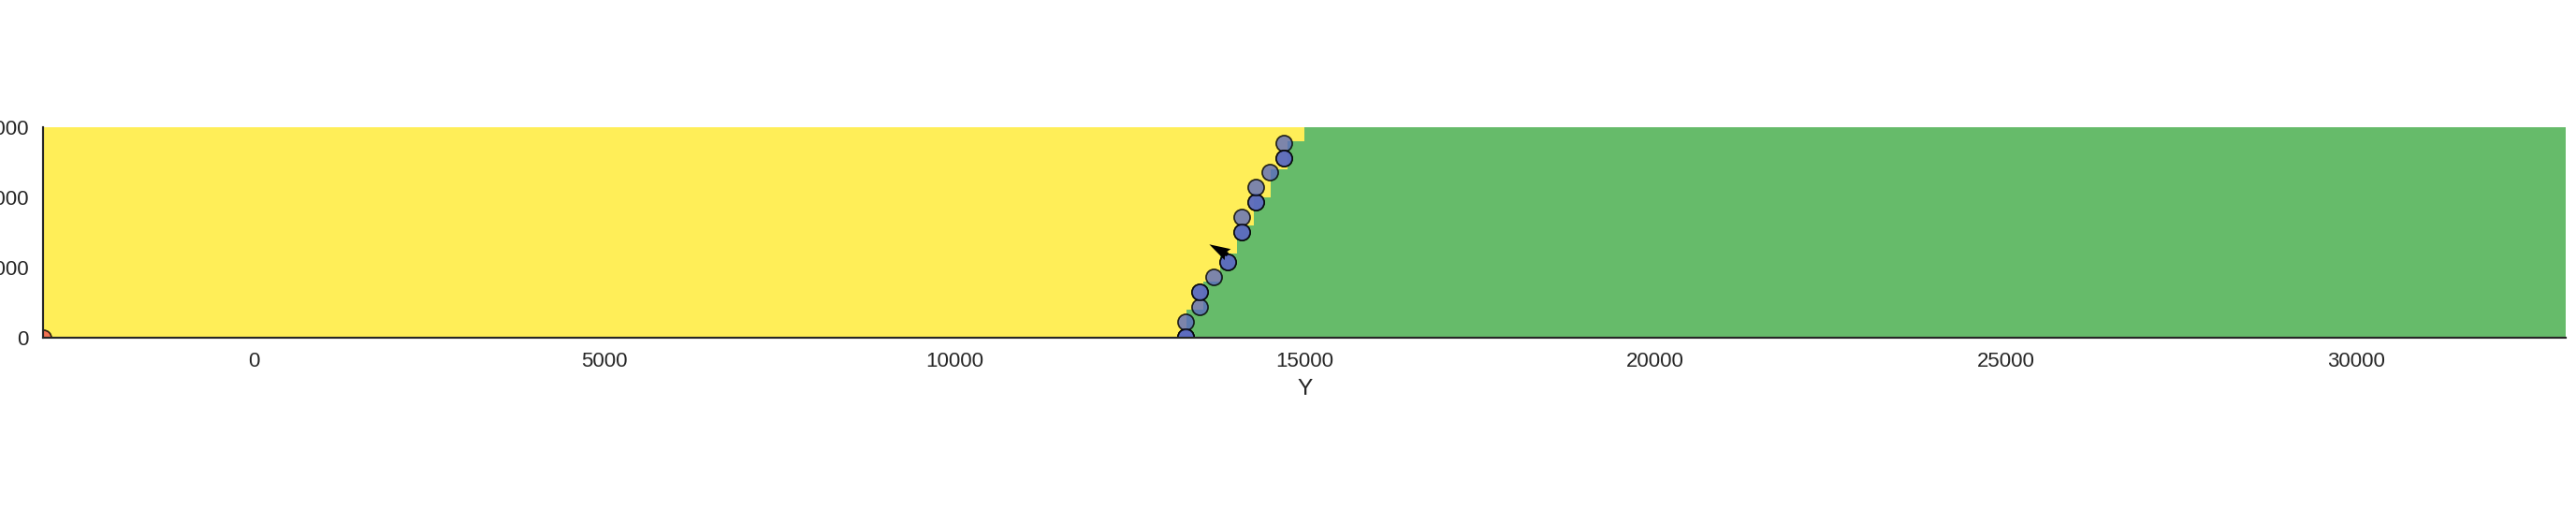

In [42]:
%matplotlib notebook
gp.plotting.plot_section(geo_data, lith2[0], 30, direction='x', plot_data= True)


<IPython.core.display.Javascript object>


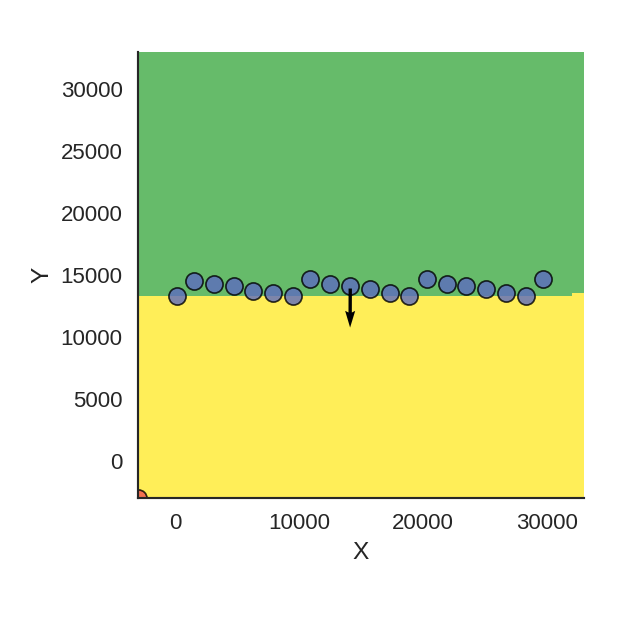

In [55]:
gp.plotting.plot_section(geo_data, lith2[0], 0, direction='z', plot_data= True)


In [ ]:
plt.plot()

In [ ]:
plt.plot(geophys.grv_data[:,0])
plt.plot(geophys2.grv_data[:,0])
plt.plot(geophys3.grv_data[:,0])
plt.plot(grav.reshape(50,50)[:,0])

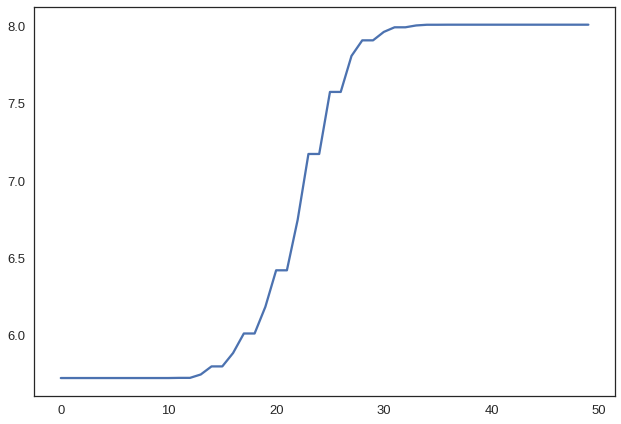

In [23]:
plt.plot(grav.reshape(50,50)[:,0])

In [40]:
interp_data_grav.geo_data_res.interfaces

,X,Y,Z,annotations,formation,formation_number,formation_value,isFault,order_series,series
0,0.710312,0.634715,0.523442,"${\bf{x}}_{\alpha \,{\bf{1}},0}$",formation_0,1,2.5,False,1,Default series
1,0.521983,0.645325,0.540380,"${\bf{x}}_{\alpha \,{\bf{1}},1}$",formation_0,1,2.5,False,1,Default series
2,0.357527,0.632063,0.514973,"${\bf{x}}_{\alpha \,{\bf{1}},2}$",formation_0,1,2.5,False,1,Default series
3,0.376095,0.647978,0.546026,"${\bf{x}}_{\alpha \,{\bf{1}},3}$",formation_0,1,2.5,False,1,Default series
4,0.397315,0.645325,0.540380,"${\bf{x}}_{\alpha \,{\bf{1}},4}$",formation_0,1,2.5,False,1,Default series
5,0.418535,0.642673,0.534734,"${\bf{x}}_{\alpha \,{\bf{1}},5}$",formation_0,1,2.5,False,1,Default series
6,0.439755,0.637368,0.526265,"${\bf{x}}_{\alpha \,{\bf{1}},6}$",formation_0,1,2.5,False,1,Default series
7,0.460975,0.634715,0.520619,"${\bf{x}}_{\alpha \,{\bf{1}},7}$",formation_0,1,2.5,False,1,Default series
8,0.482195,0.632063,0.514973,"${\bf{x}}_{\alpha \,{\bf{1}},8}$",formation_0,1,2.5,False,1,Default series
9,0.750100,0.650631,0.551673,"${\bf{x}}_{\alpha \,{\bf{1}},9}$",formation_0,1,2.5,False,1,Default series
